# Problem Statement & Description

The goal of this project is to generate images in the style of Monet by training a CycleGAN model. The CycleGAN model is a type of GAN model that learns to translate between two image domains. It consists of two generators and two discriminators. 
One generator learns to transform photos into Monet-style paintings, and the other learns to reconstruct the original photos from the generated Monet images. Likewise, there is one discriminator that learns to distinguish Monet paintings from generated ones and one discriminator that distinguishes real photos from generated reconstructions. 

This project builds off of the CycleGAN tutorial: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

The data sets are:
- 300 Monet paintings that are already sized to 256x256 and are RGB images. These will be used to train the model.
- 7,028 RGB photos sized to 256x256. These are the images that will be transformed to Monet style.

# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


# Load in the data

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Read from a TFRecord and convert the stored image bytes into a tensor for training. 

In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Load the datasets.

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# EDA

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

### Visualize Images

Let's first take a look at an example from each dataset to get a feel for them. 

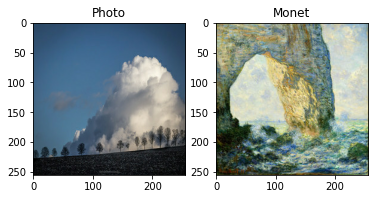

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

We can see in this sample set that the Monet painting has a softer, blurrier style typical of the artist, while the photo is crisper, showing more detail.

### Pixel Distributions

Let's compare the pixel distributions between the two datasets. We'll start just by looking at small batches of each and plotting histograms of the RGB pixels. Then we'll move onto a larger scale comparison, by looking at all of the pixels to determine if there are any key differences between the two groups. Before finishing with some descriptive statistics.

#### A sampling of Monet images and photos.

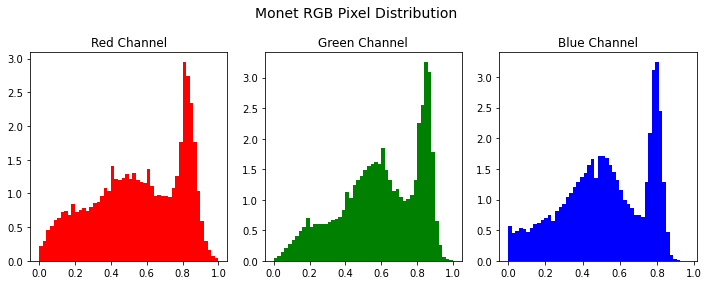

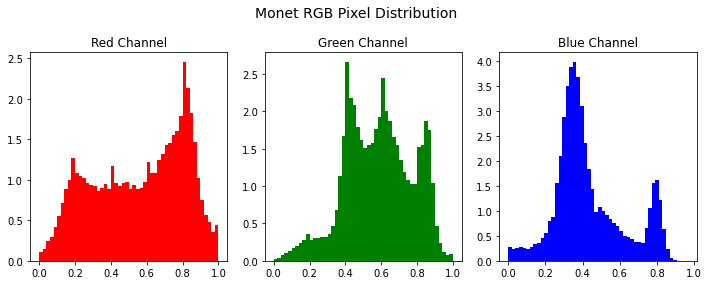

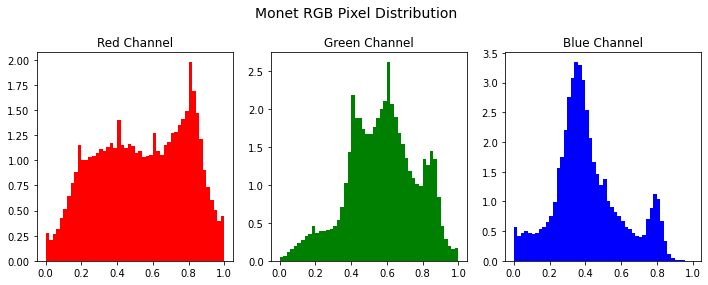

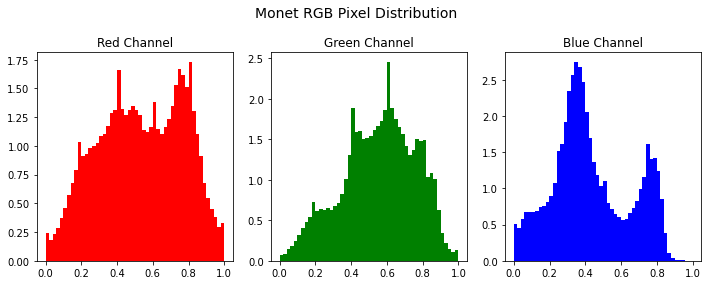

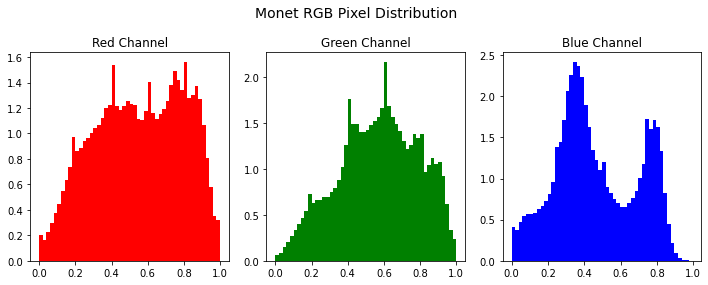

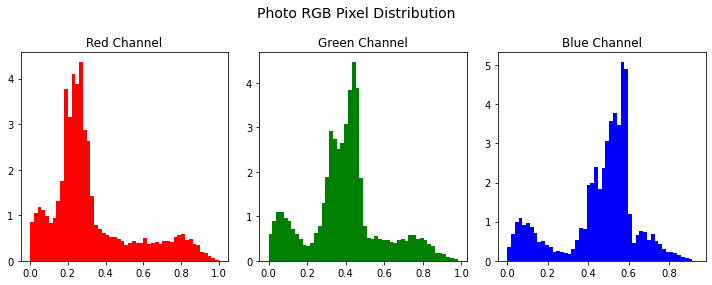

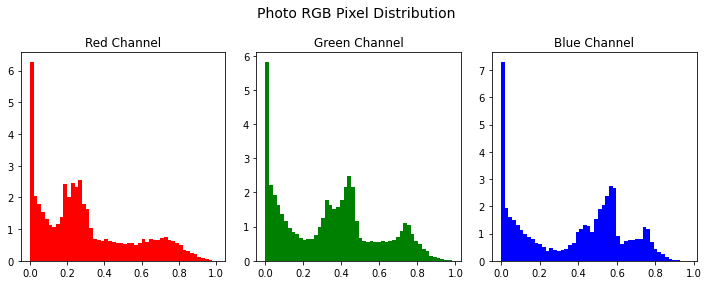

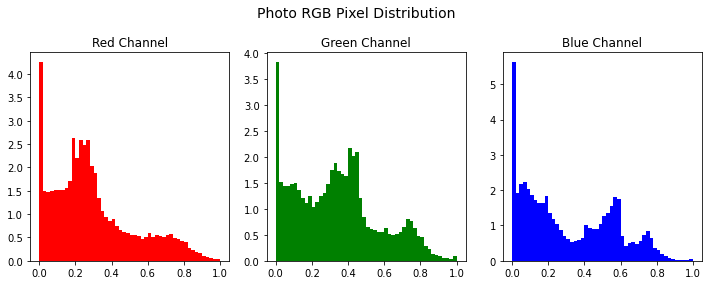

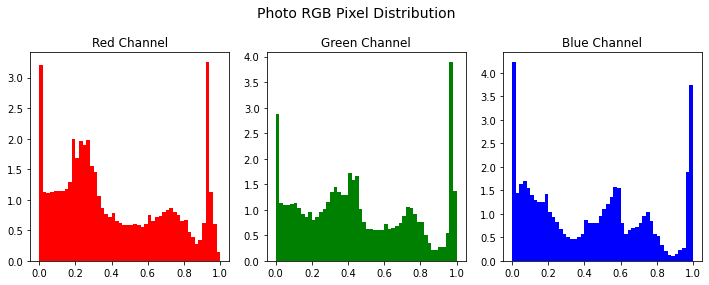

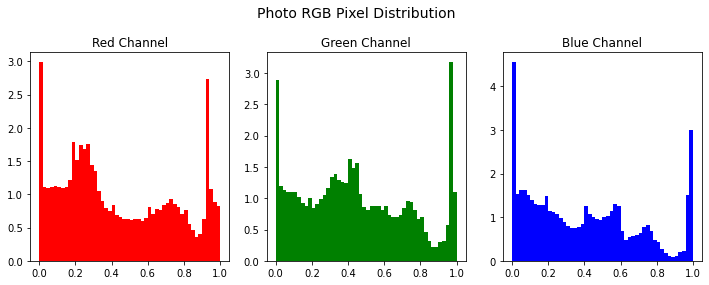

In [9]:
for domain_name, dataset in [('Monet', monet_ds), ('Photo', photo_ds)]:

    red_pixels = []
    green_pixels = []
    blue_pixels = []
    
    for batch in dataset.take(5):
        for image in batch:
                        
            image = (image + 1.0) / 2.0
    
            red = image[:, :, 0].numpy().flatten()
            green = image[:, :, 1].numpy().flatten()
            blue = image[:, :, 2].numpy().flatten()
    
            red_pixels.append(red)
            green_pixels.append(green)
            blue_pixels.append(blue)

        red_channel = np.concatenate(red_pixels)
        green_channel = np.concatenate(green_pixels)
        blue_channel = np.concatenate(blue_pixels)

        plt.figure(figsize=(10, 4))
        plt.suptitle(f"{domain_name} RGB Pixel Distribution", fontsize=14)
        
        plt.subplot(1, 3, 1)
        plt.hist(red_channel, bins=50, color='red', density=True)
        plt.title("Red Channel")

        plt.subplot(1, 3, 2)
        plt.hist(green_channel, bins=50, color='green', density=True)
        plt.title("Green Channel")


        plt.subplot(1, 3, 3)
        plt.hist(blue_channel, bins=50, color='blue', density=True)
        plt.title("Blue Channel")

        plt.tight_layout()
        plt.show()


We can see in this sample, that the Monet's tend to have very similar shades of red, green and blue to each other, evidenced by the distributions' shapes. The photo grouping is slightly more varied, but there are still some similarities within the grouping on the distributions.

Let's see if we can find any overarching differences by plotting the distribution for all images.

#### Pixel Intensity Distribution Histogram

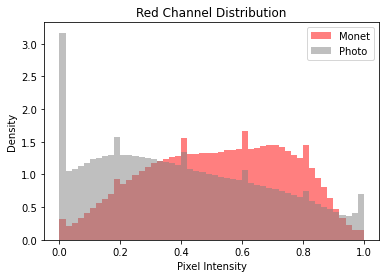

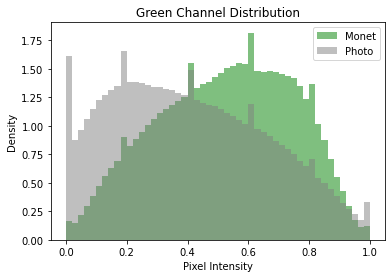

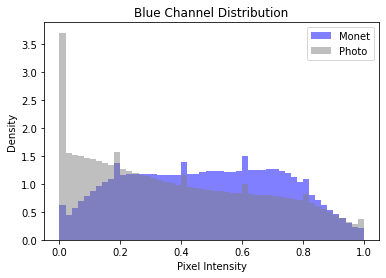

In [10]:
monet_r, monet_g, monet_b = [], [], []
photo_r, photo_g, photo_b = [], [], []

def all_pixels(dataset, r_list, g_list, b_list):

    dataset = dataset.unbatch()
    #for batch in dataset.take(300):
        #for image in batch:
    for image in dataset:
        
        #rescale images 
        image = (image + 1.0) / 2.0

        #split RGB 
        red = image[:, :, 0].numpy().flatten()
        green = image[:, :, 1].numpy().flatten()
        blue = image[:, :, 2].numpy().flatten()

        r_list.append(red)
        g_list.append(green)
        b_list.append(blue)

all_pixels(monet_ds, monet_r, monet_g, monet_b)
all_pixels(photo_ds, photo_r, photo_g, photo_b)

monet_r = np.concatenate(monet_r)
photo_r = np.concatenate(photo_r)

monet_g = np.concatenate(monet_g)
photo_g = np.concatenate(photo_g)

monet_b = np.concatenate(monet_b)
photo_b = np.concatenate(photo_b)

for channel_name, m_vals, p_vals, color in [
    ("Red", monet_r, photo_r, "red"),
    ("Green", monet_g, photo_g, "green"),
    ("Blue", monet_b, photo_b, "blue")
]:
    plt.figure(figsize=(6, 4))
    plt.hist(m_vals, bins=50, alpha=0.5, color=color, label="Monet", density=True)
    plt.hist(p_vals, bins=50, alpha=0.5, color='gray', label="Photo", density=True)
    plt.title(f"{channel_name} Channel Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

We can see by looking at the pixel intensity histograms, that the Monets tend to have moderately intense colors. This is evidenced by each of the density distributions peaking in the middle range of approximately 0.5 to 0.7. 

In contrast, the photos peak near zero in all three channels, suggesting lower intensity pixels, which may correspond to neutral and muted tones. The right skewed shape of each channel does suggest some brighter colored areas exist, but they are far less common.

#### Descriptive Statitistics

Lets dig a little further into the pixel intensities to calculate the mean and standard deviation.

In [11]:
mean_m_r = round(np.mean(monet_r),4)
mean_m_g = round(np.mean(monet_g),4)
mean_m_b = round(np.mean(monet_b),4)

mean_p_r = round(np.mean(photo_r),4)
mean_p_g = round(np.mean(photo_g),4)
mean_p_b = round(np.mean(photo_b),4)

std_m_r = round(np.std(monet_r),4)
std_m_g = round(np.std(monet_g),4)
std_m_b = round(np.std(monet_b),4)

std_p_r = round(np.std(photo_r),4)
std_p_g = round(np.std(photo_g),4)
std_p_b = round(np.std(photo_b),4)

data = {
    'dataset': ['monet', 'photo'],
    'mean_red': [mean_m_r, mean_p_r],
    'std_red': [std_m_r, std_p_r],
    'mean_green': [mean_m_g,mean_p_g],
    'std_green': [std_m_g, std_p_g],
    'mean_blue': [mean_m_b, mean_p_b],
    'std_blue': [std_m_b,std_p_b]
}


descriptive_stats_table = pd.DataFrame(data)
display(descriptive_stats_table)

,dataset,mean_red,std_red,mean_green,std_green,mean_blue,std_blue
0,monet,0.5215,0.228,0.5243,0.2201,0.4767,0.2471
1,photo,0.4034,0.272,0.4085,0.2497,0.3827,0.2781


The descriptive statistics further confirm the conclusions drawn from the pixel intensity histograms. Monet paintings tend to have muted blues, greens and reds evidenced by the color channels' mean values being approximately between 0.48 and 0.52. These results align with what we know anecdotally about Monet's work being soft in tone and color. 

Conversely, the photos have lower mean values, approximately between 0.38 and 0.41, indicating a tendency toward darker or more neutral tones. Their slightly higher standard deviations suggest that while most image content is neutral, there are some regions of brighter or more saturated colors, contributing to more variability.


### EDA Summary

Through exploratory data analysis, we found that Monet paintings tend to have moderate pixel intensity across all color channels, resulting in muted reds, greens and blues. We also found that the photos contain darker, more neutral tones, but there are some instances of brighter more saturated areas. 

# Model Architecture

The generator and discrimantor architectures used in this CycleGAN implementation are based on the tutorial, but include meaningful changes I made through testing and tuning. 

### Generator Modifications:
- **Downsampling**: Reduced the number of downsampling layers from 8 to 6 to help the generator keep more detail from the original image.
- **Upsampling**: Instead of using Conv2DTranspose (which caused visible checkerboard patterns), I switched to bilinear upsampling followed by a Conv2D layer. This helped create smoother and more natural looking results.
- **Normalization**: Kept InstanceNormalization in the upsampling path, which helped keep the style consistent across images.
- **Dropout**: Applied dropout only to the first two upsampling layers. This was enough to prevent overfitting without losing too much detail in the final output.
- **Activations**: Lowered the slope of LeakyReLU to 0.1 instead of the default 0.2 to make the activation less aggressive. 
- **Skip Connections**: Preserved the U-Net style skip connections to support reconstruction of fine details.
- **Residual Blocks**: Removed from the final version after experimental testing showed no performance gain in this context.


### Discriminator Modifications:
- **Architecture**: Added an extra downsampling block but kept the final conv layer connected to down3. This was initially done accidentally, but ended up improving performance. 
- **Normalization**: Replaced InstanceNormalization with GroupNormalization (with 16 groups).
- **Activations**: Used slope of 0.1 for LeakyReLU instead of default 0.2.

In [12]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

#Residual blocks, which did not end up improving performance 

#def residual_block(input_layer, filters):

    #initializer = tf.random_normal_initializer(0., 0.02)
    
    #block = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                      #kernel_initializer=initializer, use_bias=False)(input_layer)

    #block = tfa.layers.InstanceNormalization()(block)
    #block = layers.ReLU()(block)

    #block = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                      #kernel_initializer=initializer, use_bias=False)(block)

    #block = tfa.layers.InstanceNormalization()(block)

    #block = layers.Add()([block, input_layer])

    #return block

## Build Generator & Discriminator

In [15]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [

        downsample(64, 4, apply_norm=False), 
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        #downsample(512, 4), 
        #downsample(512, 4), 
        downsample(512, 4), 
    ]

    
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        #upsample(512, 4, apply_dropout=True), 
        #upsample(512, 4), 
        upsample(256, 4), 
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 

    x = inputs

    # Downsampling 
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    #Residual blocks
    #for _ in range(3):
        #x = residual_block(x, filters=512)

    # Upsampling 
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [14]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 
    down4 = downsample(512, 4)(down3) 
    
    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    #norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    norm1 = tfa.layers.GroupNormalization(groups=16)(conv)
    
    leaky_relu = layers.LeakyReLU(alpha=0.1)(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [16]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

## Build the CycleGAN model

In [18]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Define loss functions

In [19]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [20]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [21]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [22]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Train the CycleGAN

Let's compile our model. 

In [23]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [25]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50
)

Epoch 1/100
300/300 [==============================] - 112s 244ms/step - monet_gen_loss: 5.0906 - photo_gen_loss: 5.3120 - monet_disc_loss: 0.6530 - photo_disc_loss: 0.6078
Epoch 2/100
300/300 [==============================] - 74s 244ms/step - monet_gen_loss: 3.5648 - photo_gen_loss: 3.6992 - monet_disc_loss: 0.6738 - photo_disc_loss: 0.6434
Epoch 3/100
300/300 [==============================] - 74s 244ms/step - monet_gen_loss: 3.4941 - photo_gen_loss: 3.6241 - monet_disc_loss: 0.6597 - photo_disc_loss: 0.6268
Epoch 4/100
300/300 [==============================] - 74s 244ms/step - monet_gen_loss: 3.4021 - photo_gen_loss: 3.5143 - monet_disc_loss: 0.6439 - photo_disc_loss: 0.6228
Epoch 5/100
300/300 [==============================] - 74s 244ms/step - monet_gen_loss: 3.2917 - photo_gen_loss: 3.3547 - monet_disc_loss: 0.6302 - photo_disc_loss: 0.6280
Epoch 6/100
300/300 [==============================] - 74s 243ms/step - monet_gen_loss: 3.2132 - photo_gen_loss: 3.2445 - monet_disc_loss: 

In [26]:
import pickle

with open("cycle_gan_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Plot Loss Functions

In [30]:
monet_gen = [np.mean(x) for x in history.history['monet_gen_loss']]
photo_gen = [np.mean(x) for x in history.history['photo_gen_loss']]

monet_disc = [np.mean(x) for x in history.history['monet_disc_loss']]
photo_disc= [np.mean(x) for x in history.history['photo_disc_loss']]

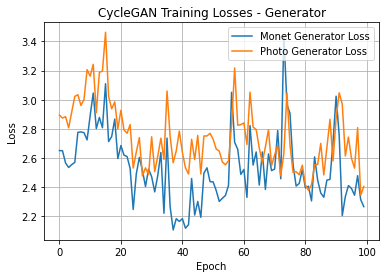

In [32]:
plt.plot(monet_gen, label='Monet Generator Loss')
plt.plot(photo_gen, label='Photo Generator Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CycleGAN Training Losses - Generator')
plt.legend()
plt.grid(True)
plt.show()

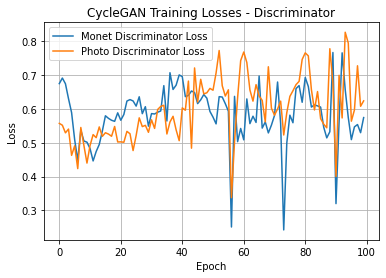

In [33]:
plt.plot(monet_disc, label='Monet Discriminator Loss')
plt.plot(photo_disc, label='Photo Discriminator Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CycleGAN Training Losses - Discriminator')
plt.legend()
plt.grid(True)
plt.show()

## Loss Function Summary

Based on the loss plots, we can see the loss functions for the generators and discriminators remain relatively close between the Monet and photo domains, suggesting balanced learning between the two directions of translations. In addition, because the generator and discriminator losses have not clearly converged or plateaued, it suggests that further training (additional epochs) may allow for continued improvement.

## Tuning

While the architecture above produced the best results, it took many iterations to get there. We initially began by removing a couple of layers from the tutorial model, but this did not lead to any improvement. We then reverted to the original 8 downsampling and 7 upsampling blocks but added an additional dropout layer in the upper levels of the upsampling path. This change led to some improvement, so we next experimented by adding 3 residual blocks. However, performance declined, so the residual blocks were removed. Increasing the number of training epochs to 100 yielded our second best score of 50.09.

From there, we made more substantial changes to better personalize the architecture. We experimented with additional downsampling layers, reducing layers again, adding dropout to the discriminator, reintroducing residual blocks, and reducing kernel size, keeping any changes that appeared to improve image quality. A breakthrough came when we replaced InstanceNormalization with GroupNormalization in the downsampling blocks, which significantly improved results. However, one image exhibited a checkered sky pattern, prompting us to swap Conv2DTranspose for bilinear upsampling followed by a Conv2D layer. This final change eliminated the artifact. When the notebook was rerun, the results were promising, ultimately yielding our best score of 50.00.

# Evaluation

## Visualize our Monet-esque photos

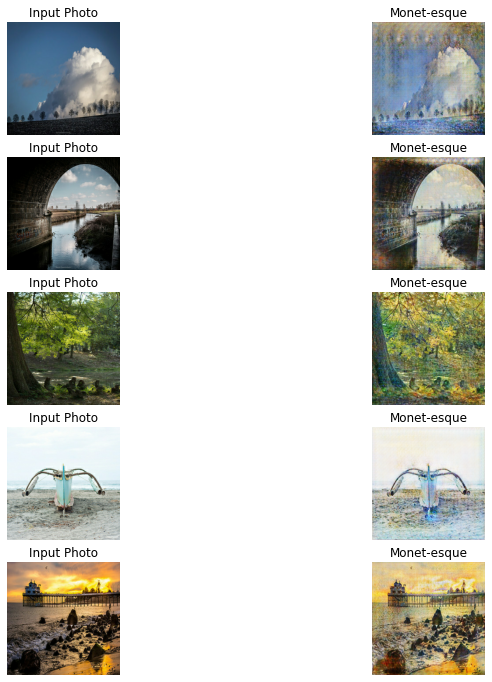

In [28]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Evaluation Summary

The output images exhibit a soft, 'blurry' look with more vibrant hues than the input photos, which aligns with Monet's aesthetic. 

# Create submission file

In [ ]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# Conclusion & Discussion

Tuning the original CycleGAN architecture and its hyperparameters led to improved performance over the baseline configuration. In particular, pairing GroupNormalization in the discriminator with bilinear upsampling followed by a Conv2D layer in the upsampling path proved to be key to our success.

Future experimentation could include adjusting the learning rate, as described the original CycleGAN paper, where it remains constant for the first 100 epochs and then linearly decays over the next 100 epochs. Other areas worth exploring are experimenting with different loss functions or applying data augmentation to improve robustness.

##### References

1. J. -Y. Zhu, T. Park, P. Isola and A. A. Efros, "Unpaired Image-to-Image Translation Using Cycle-Consistent Adversarial Networks," 2017 IEEE International Conference on Computer Vision (ICCV), Venice, Italy, 2017, pp. 2242-2251, doi: 10.1109/ICCV.2017.244. keywords: {Training;Painting;Training data;Semantics;Extraterrestrial measurements;Graphics},
